In [19]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

In [28]:
# Function to load the data for a specific season
def load_data(season):
    url = f'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{season}/players_raw.csv'
    data = pd.read_csv(url)
    return data

# Load all data from multiple seasons
seasons = ['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
dfs = [load_data(season) for season in seasons]
fpl_data = pd.concat(dfs, ignore_index=True)

# Define relevant columns to keep for training
relevant_columns = [
    'assists', 'bonus', 'bps', 'chance_of_playing_next_round', 'chance_of_playing_this_round',
    'clean_sheets', 'clean_sheets_per_90', 'cost_change_event', 'cost_change_event_fall',
    'cost_change_start', 'cost_change_start_fall', 'creativity', 'creativity_rank', 
    'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'expected_assists', 
    'expected_assists_per_90', 'expected_goal_involvements', 'expected_goal_involvements_per_90',
    'expected_goals', 'expected_goals_conceded', 'expected_goals_conceded_per_90', 
    'expected_goals_per_90', 'form', 'form_rank', 'goals_conceded', 'goals_conceded_per_90', 
    'goals_scored', 'ict_index', 'ict_index_rank', 'id', 'in_dreamteam', 'influence', 
    'influence_rank', 'minutes', 'now_cost', 'now_cost_rank', 'penalties_missed', 
    'penalties_saved', 'points_per_game', 'points_per_game_rank', 'red_cards', 'saves', 
    'saves_per_90', 'starts', 'starts_per_90', 'team', 'team_code', 
    'threat', 'threat_rank', 'total_points', 'transfers_in', 'transfers_out', 
    'value_form', 'value_season', 'yellow_cards'
]

# Keep only relevant columns for training
available_columns = [col for col in relevant_columns if col in fpl_data.columns]
fpl_data_relevant = fpl_data[available_columns]

# Handle missing values by imputing the mean for numeric columns
numeric_columns = fpl_data_relevant.select_dtypes(include=[np.number]).columns
numeric_imputer = SimpleImputer(strategy='mean')
fpl_data_numeric_imputed = pd.DataFrame(numeric_imputer.fit_transform(fpl_data_relevant[numeric_columns]), columns=numeric_columns)

# Rejoin non-numeric columns
categorical_columns = [col for col in available_columns if col not in numeric_columns]
fpl_data_non_numeric = fpl_data_relevant[categorical_columns]
fpl_data_imputed = pd.concat([fpl_data_numeric_imputed, fpl_data_non_numeric.reset_index(drop=True)], axis=1)

# Normalize total_points to a rating between 50 and 100, incorporating player price
def normalize_ratings_by_position_train(data):
    positions = [1, 2, 3, 4]  # GK:1, DEF:2, MID:3, FWD:4
    normalized_data = pd.DataFrame()
    min_max_points = {}
    
    for pos in positions:
        pos_data = data[data['element_type'] == pos].copy()
        if 'total_points' not in pos_data.columns or 'now_cost' not in pos_data.columns:
            continue
        
        # Calculate min and max points for the position
        min_points = pos_data['total_points'].min()
        max_points = pos_data['total_points'].max()
        min_max_points[pos] = (min_points, max_points)
        
        # Get the maximum cost for this position
        max_cost = pos_data['now_cost'].max()
        
        # Normalize points and adjust based on the price ratio
        pos_data['rating'] = np.round(
            normalize_ratings_with_price(
                pos_data['total_points'], min_points, max_points, pos_data['now_cost'], max_cost
            )
        ).astype(int)
        
        normalized_data = pd.concat([normalized_data, pos_data], ignore_index=True)
    
    return normalized_data, min_max_points

# Modified normalization function with price adjustment
def normalize_ratings_with_price(points, min_points, max_points, player_cost, max_cost):
    price_ratio = (player_cost / max_cost)   # Ratio between 0 and 1 based on player cost and max cost
    # Adjust rating by dividing by the price ratio (1 for max cost, lower for cheaper players)
    performance_rating = 50 + ((points - min_points) / (max_points - min_points) * 50)
    
    # 3. Calculate the price-adjusted part (this part will contribute 30% to the final rating)
    price_adjustment = 50 + ((points - min_points) / (max_points - min_points) * 50) / price_ratio
    
    # 4. Blend the performance-based rating and the price-adjusted rating (70% performance, 30% price)
    final_rating = 0.65 * performance_rating + 0.35 * price_adjustment
    return final_rating

# Normalize and store min/max points
fpl_data_imputed, min_max_points = normalize_ratings_by_position_train(fpl_data_imputed)

# Prepare features and target variable
X = fpl_data_imputed.drop(['total_points', 'rating'], axis=1, errors='ignore')
y = fpl_data_imputed['rating']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = np.round(rf_model.predict(X_test)).astype(int)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Save the model, scaler, and min/max points
joblib.dump(rf_model, 'fpl_rating_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(min_max_points, 'min_max_points.pkl')
print("Model, scaler, and min/max points saved.")


Mean Absolute Error: 0.36
Mean Squared Error: 0.65
R^2 Score: 1.00
Model, scaler, and min/max points saved.


In [29]:
# Load the trained model, scaler, and min/max points
rf_model = joblib.load('fpl_rating_model.pkl')
scaler = joblib.load('scaler.pkl')
min_max_points = joblib.load('min_max_points.pkl')

# Function to load the data for the 2023-24 season
def load_data(season):
    url = f'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{season}/players_raw.csv'
    data = pd.read_csv(url)
    return data

# Load 2023-24 season data
fpl_data_2023_24 = load_data('2023-24')

# Define relevant columns to keep for model input (but not drop any others)
relevant_columns = [
    'assists', 'bonus', 'bps', 'chance_of_playing_next_round', 'chance_of_playing_this_round',
    'clean_sheets', 'clean_sheets_per_90', 'cost_change_event', 'cost_change_event_fall',
    'cost_change_start', 'cost_change_start_fall', 'creativity', 'creativity_rank', 
    'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'expected_assists', 
    'expected_assists_per_90', 'expected_goal_involvements', 'expected_goal_involvements_per_90',
    'expected_goals', 'expected_goals_conceded', 'expected_goals_conceded_per_90', 
    'expected_goals_per_90', 'form', 'form_rank', 'goals_conceded', 'goals_conceded_per_90', 
    'goals_scored', 'ict_index', 'ict_index_rank', 'id', 'in_dreamteam', 'influence', 
    'influence_rank', 'minutes', 'now_cost', 'now_cost_rank', 'penalties_missed', 
    'penalties_saved', 'points_per_game', 'points_per_game_rank', 'red_cards', 'saves', 
    'saves_per_90', 'starts', 'starts_per_90', 'team', 'team_code', 
    'threat', 'threat_rank', 'total_points', 'transfers_in', 'transfers_out', 
    'value_form', 'value_season', 'yellow_cards'
]

# Keep relevant columns for prediction
available_columns = [col for col in relevant_columns if col in fpl_data_2023_24.columns]
fpl_data_2023_24_relevant = fpl_data_2023_24[available_columns]

# Handle missing values for numeric columns
numeric_columns = fpl_data_2023_24_relevant.select_dtypes(include=[np.number]).columns
numeric_imputer = SimpleImputer(strategy='mean')
fpl_data_numeric_imputed = pd.DataFrame(numeric_imputer.fit_transform(fpl_data_2023_24_relevant[numeric_columns]), columns=numeric_columns)

# Rejoin non-numeric columns
categorical_columns = [col for col in available_columns if col not in numeric_columns]
fpl_data_non_numeric = fpl_data_2023_24_relevant[categorical_columns]
fpl_data_2023_24_imputed = pd.concat([fpl_data_numeric_imputed, fpl_data_non_numeric.reset_index(drop=True)], axis=1)

# Modified normalization function with price adjustment for prediction
def normalize_ratings_with_price(points, min_points, max_points, player_cost, max_cost):
    price_ratio = (player_cost / max_cost)   # Ratio between 0 and 1 based on player cost and max cost
    # Adjust rating by dividing by the price ratio (1 for max cost, lower for cheaper players)
    performance_rating = 50 + ((points - min_points) / (max_points - min_points) * 50)
    
    # 3. Calculate the price-adjusted part (this part will contribute 30% to the final rating)
    price_adjustment = 50 + ((points - min_points) / (max_points - min_points) * 50) / price_ratio
    
    # 4. Blend the performance-based rating and the price-adjusted rating (70% performance, 30% price)
    final_rating = 0.65 * performance_rating + 0.35 * price_adjustment
    return final_rating 

# Normalize total_points to a rating between 0 and 100 using training min/max points and price adjustment
def normalize_ratings_by_position_test(data, min_max_points):
    positions = [1, 2, 3, 4]  # GK:1, DEF:2, MID:3, FWD:4
    normalized_data = pd.DataFrame()

    for pos in positions:
        pos_data = data[data['element_type'] == pos].copy()
        if 'total_points' not in pos_data.columns or 'now_cost' not in pos_data.columns:
            continue
        
        # Get the min/max points and max cost from training
        train_min_points, train_max_points = min_max_points.get(pos, (0, 1))
        max_cost = pos_data['now_cost'].max()
        
        # Adjust min/max points based on the current season's data
        season_min_points = pos_data['total_points'].min()
        season_max_points = pos_data['total_points'].max()
        min_points = min(train_min_points, season_min_points)
        max_points = max(train_max_points, season_max_points)
        
        # Normalize points considering player price
        pos_data['rating'] = np.round(
            normalize_ratings_with_price(
                pos_data['total_points'], min_points, max_points, pos_data['now_cost'], max_cost
            )
        ).astype(int)
        
        normalized_data = pd.concat([normalized_data, pos_data], ignore_index=True)
    
    return normalized_data

# Normalize the 2023-24 data using adjusted min/max points
fpl_data_2023_24_imputed = normalize_ratings_by_position_test(fpl_data_2023_24_imputed, min_max_points)

# Scale features for prediction (excluding 'total_points' and 'rating')
X_2023_24 = fpl_data_2023_24_imputed.drop(['total_points', 'rating'], axis=1, errors='ignore')
X_2023_24_scaled = scaler.transform(X_2023_24)

# Predict ratings for the 2023-24 season
y_2023_24_pred = np.round(rf_model.predict(X_2023_24_scaled)).astype(int)

# Add predicted ratings to the processed DataFrame (with only imputed columns)
fpl_data_2023_24_imputed['predicted_rating'] = y_2023_24_pred

# Merge the predicted ratings with the original data using the 'id' column
fpl_data_2023_24_with_ratings = pd.merge(fpl_data_2023_24, fpl_data_2023_24_imputed[['id', 'predicted_rating']], on='id', how='left')

# Save the updated 2023-24 data with ratings to a CSV
fpl_data_2023_24_with_ratings.to_csv('fpl_data_2023_24_with_ratings.csv', index=False)

print("Predictions saved to 'fpl_data_2023_24_with_ratings.csv'.")


Predictions saved to 'fpl_data_2023_24_with_ratings.csv'.


In [30]:
# Ground truth (actual total points as ratings) and predicted ratings
y_true = fpl_data_2023_24_imputed['rating']  # Actual normalized ratings
y_pred = fpl_data_2023_24_imputed['predicted_rating']  # Predicted ratings

# Calculate regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 0.16
Mean Squared Error (MSE): 0.30
R-squared (R²): 1.00


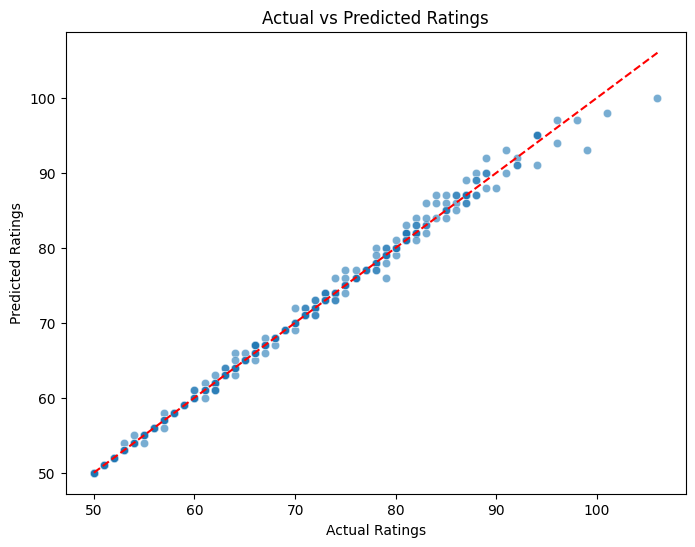

In [31]:
# Scatter plot for actual vs predicted ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')  # Diagonal line
plt.show()

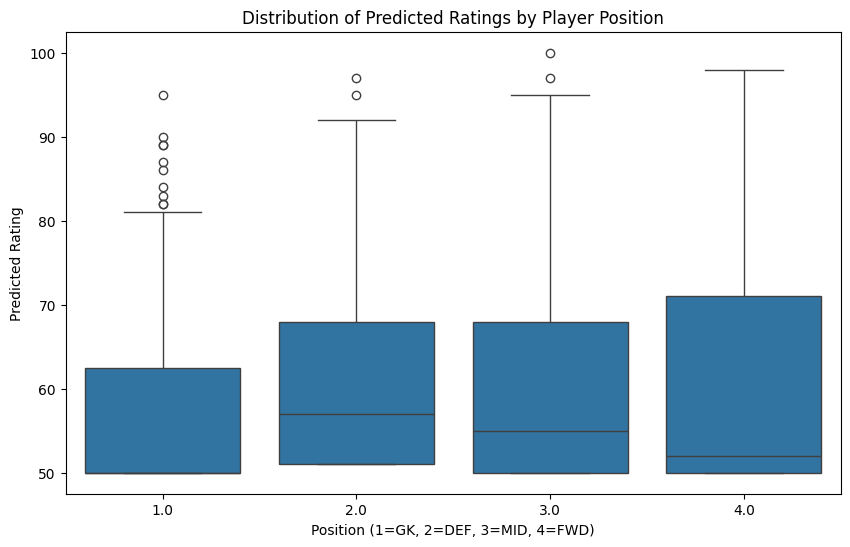

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=fpl_data_2023_24_imputed['element_type'], y=fpl_data_2023_24_imputed['predicted_rating'])
plt.xlabel('Position (1=GK, 2=DEF, 3=MID, 4=FWD)')
plt.ylabel('Predicted Rating')
plt.title('Distribution of Predicted Ratings by Player Position')
plt.show()

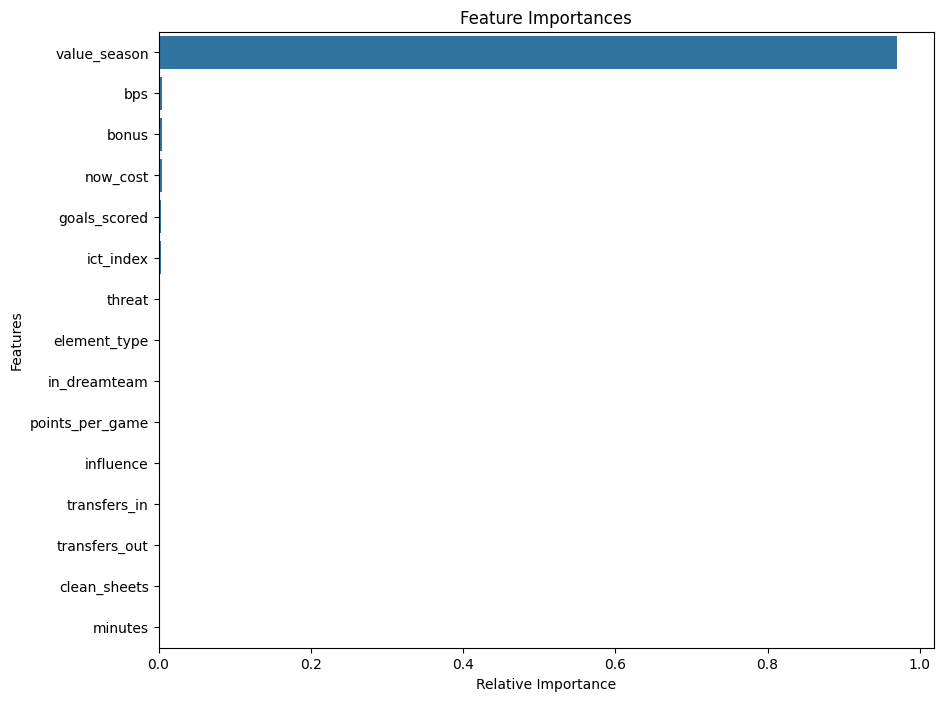

In [33]:
# Feature importance plot
importances = rf_model.feature_importances_
feature_names = X.columns  # Ensure you're using the correct DataFrame for feature names

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()


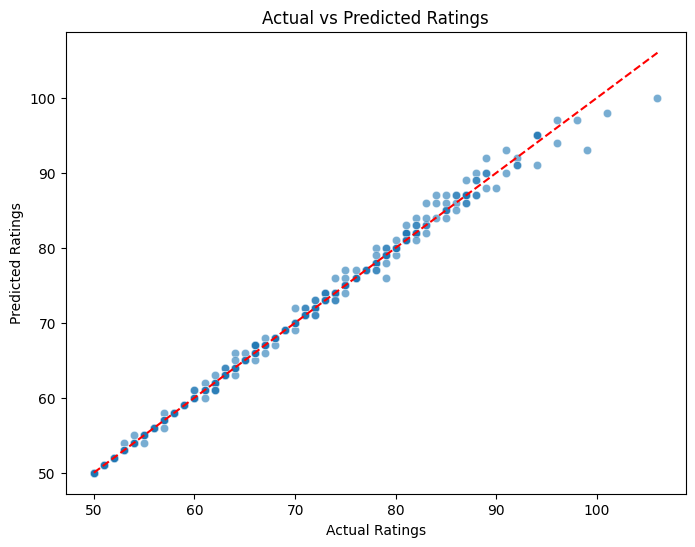

In [34]:
# Save scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
plt.savefig('actual_vs_predicted_ratings.png')

# Save metrics to a text file
with open('model_evaluation.txt', 'w') as f:
    f.write(f"Mean Absolute Error (MAE): {mae:.2f}\n")
    f.write(f"Mean Squared Error (MSE): {mse:.2f}\n")
    f.write(f"R-squared (R²): {r2:.2f}\n")
